In [1]:
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV,train_test_split
sys.path.append("/home/mindy/Documents/projects/creditCardFraud/scripts/")
import warnings
warnings.filterwarnings("ignore")

In [2]:
from util import *

In [3]:
%load_ext autoreload
%autoreload 2

### Simple Isolation Forest Algorithm :

* Forest: composed many trees 

* Isolation Tree:
     * external node 
     * internal node 
     * randomly choose a feature and randomly choose a value in the feature between max and min and split the data
     

* Metrics: Path Length  

  * abnormal cases tend to have shorter path length than normal cases 

### Basic forest constructions

In [4]:
class ExNode:
    def __init__(self,size):
        self.size = size 
        
class InNode:
    def __init__(self,left,right,splitAt,splitVal):
        self.left = left
        self.right = right
        self.splitAt = splitAt 
        self.splitVal = splitVal

In [5]:
def Tree(data,currLength,maxDepth):
    # either max depth or only one sample left 
    if currLength >=maxDepth or data.shape[0] <=1:  
        return ExNode(data.shape[0])  # the num of sample per external node 
    else:
        allFeatures = data.columns
        chosenF = np.random.choice(allFeatures,1)[0]  # randomly choose a feature 
        chosenV = np.random.choice(data[chosenF].unique(),1)[0] # randomly choose a split value with the chosen feature 
        left = data[data[chosenF]<chosenV]
        right = data[data[chosenF]>=chosenV]
        return InNode(Tree(left,currLength+1,maxDepth),Tree(right,currLength+1,maxDepth),chosenF,chosenV)        

In [6]:
def pathLength(data,Tree,currLength):
    if isinstance(Tree,ExNode): # if it is an external node
        return currLength 
    # if an internal node 
    feature = Tree.splitAt 
    if data[feature] < Tree.splitVal: 
        return pathLength(data,Tree.left,currLength+1)  # traverse down the left branch 
    else:
        return pathLength(data,Tree.right,currLength+1)

In [7]:
def Forest(data,numTrees, subsamplingSize):
    # the maxDepth in the paper is log2(n), n is numer of samples 
    maxDepth = int(np.ceil(np.log2(subsamplingSize)))
    forest = [Tree(data.sample(subsamplingSize),0,maxDepth) for i in range(numTrees)]
    return forest

### Import data 

In [8]:
train = pd.read_csv("../processedData/TrainingData_normal.csv")
dev = pd.read_csv("../processedData/DevData_normal.csv")
test = pd.read_csv("../processedData/hold_outset_moreFraud.csv")

### Generate train, test, and normal data 

In [9]:
training, norm, test_data, y_test = train_test_dfs(train,dev,test,"Class",0.2,1989)

### Test one simple isolation Forest 

* in this case just simply wanting to see fraud cases actually have shorter pathlength 

In [10]:
forest = Forest(test_data,30,1000)

In [11]:
norm_classes = test_data[y_test==0]
fraud_classes = test_data[y_test==1]
n_sample = fraud_classes.shape[0]
sub_norm_classes = norm_classes.sample(n_sample)

In [12]:
norm_pL=[]
for i in range(n_sample):
    row = sub_norm_classes.iloc[i]
    L = []
    for tr in forest:
        L.append(pathLength(row,tr,0))
    norm_pL.append(np.mean(L))

In [13]:
fraud_pL=[]
for i in range(n_sample):
    row = fraud_classes.iloc[i]
    L = []
    for tr in forest:
        L.append(pathLength(row,tr,0))
    fraud_pL.append(np.mean(L))

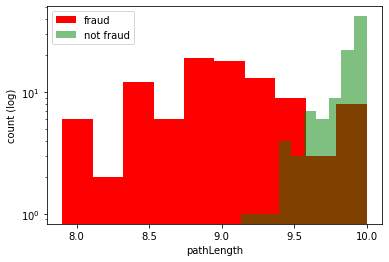

In [14]:
plot_relationship(norm_data=norm_pL,fraud_data=fraud_pL,feature_name="pathLength")

### Appears that fraud cases do have shorter pathLength than non fraud cases even though pathLength is not normalized by tree depth 

### Use more sophiscated Sklearn Isolation forest 

### the parameters are from trial and error 

In [57]:
contam=training.Class.value_counts(normalize=True).loc[1] 
iFor_norm = IsolationForest(n_estimators=80, max_samples=0.8, contamination=contam*1.5,max_features=1.0, 
                        bootstrap=False,random_state=42, n_jobs=20)
iFor_all = IsolationForest(n_estimators=80, max_samples=0.8, contamination=contam*1.5,max_features=1.0, 
                        bootstrap=False,random_state=42, n_jobs=20)

### Isolation Forest is supposed to be insensitive to outliers in the training dataset and we shall see if we get comparable outcome with normal vs data with fraud observations 

In [58]:
iFor_norm.fit(norm)
iFor_all.fit(training.drop("Class",axis=1))

IsolationForest(contamination=0.002607035484649652, max_samples=0.8,
                n_estimators=80, n_jobs=20, random_state=42)

In [59]:
pred_score_norm = iFor_norm.decision_function(test_data)
pred_score_all = iFor_all.decision_function(test_data)

In [60]:
pd.DataFrame(pred_score_all).describe()

,0
count,56962.000000
mean,0.160984
std,0.020926
min,-0.295073
25%,0.157049
50%,0.165796
75%,0.171551
max,0.183105


In [61]:
pd.DataFrame(pred_score_norm).describe()

,0
count,56962.000000
mean,0.150670
std,0.023083
min,-0.318697
25%,0.145813
50%,0.155953
75%,0.162389
max,0.173886


In [62]:
model_results(y_test,-pred_score_norm,0.0)  # negative score in sklearn version means abnormal 

[[56722   144]
 [   36    60]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.29      0.62      0.40        96

    accuracy                           1.00     56962
   macro avg       0.65      0.81      0.70     56962
weighted avg       1.00      1.00      1.00     56962



In [63]:
model_results(y_test,-pred_score_all,0.0) 

[[56776    90]
 [   53    43]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.32      0.45      0.38        96

    accuracy                           1.00     56962
   macro avg       0.66      0.72      0.69     56962
weighted avg       1.00      1.00      1.00     56962



### Didn't appear to have a huge difference if train on all normal or contaminated samples. 

* but proves that Isolation forest is not as sensitive to outlier the same way as OneClassSVM but normal class only is still better 

### Try gridSearchCV and create pseudo label to see if the outcome of grid search matches with orthognol tuning
  ### metrics are not the best for tuning since the class is very imbalanced 

In [64]:
parameters = {
              "n_estimators":[80,120],
              "max_samples":[0.5,0.8],
              "contamination":[contam*1.5, contam*2.0]
}

CV = GridSearchCV(IsolationForest(max_features=1.0,
                  bootstrap=False, random_state=42),
                  parameters,
                  scoring="f1_micro",
                  n_jobs=20,
                  verbose=1,
                  cv=2
                 )

### make sure y_true matches -1 for abnormal and 1 for normal 

In [65]:
y_true = np.ones(norm.shape[0])

In [66]:
cvResults = CV.fit(norm,y_true)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  11 out of  16 | elapsed:   50.0s remaining:   22.7s
[Parallel(n_jobs=20)]: Done  16 out of  16 | elapsed:   51.6s finished


In [67]:
cvResults.best_params_, cvResults.best_score_

({'contamination': 0.002607035484649652,
  'max_samples': 0.8,
  'n_estimators': 80},
 0.9973444586318939)

In [68]:
best_model = cvResults.best_estimator_

In [69]:
best_pred_score = best_model.decision_function(test_data)

In [70]:
model_results(y_test,-best_pred_score,0.0)

[[56722   144]
 [   36    60]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.29      0.62      0.40        96

    accuracy                           1.00     56962
   macro avg       0.65      0.81      0.70     56962
weighted avg       1.00      1.00      1.00     56962



### It appears that gridSearch reaches same conclusion as orthogonal tuning 